# DeepHit

This notebook implements the DeepHit survival model for Heart Failure patients (with functional covariates).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from lifelines.utils import concordance_index
from tqdm import tqdm

from utils.deep_hit_utils import *
from utils.common import *

In [2]:
# load data
df = pd.read_csv('../../data/main_process_preprocessed_data.csv')
test = pd.read_csv('../../data/main_process_preprocessed_data_test.csv')

In [3]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Prepare data

In [4]:
# set time windows parameters
T_max = 365*10
n_times = int(T_max/60)
# discretise time
df['discretised_time_event'] = [int(v) for v in df.time_event/T_max*n_times]

print('(Arbitrary) maximum survival time:',np.round(T_max/365,1),'years')
print('Number of time steps:',n_times)
print('Size time step:',np.round(T_max/n_times/30,1),'months')

(Arbitrary) maximum survival time: 10.0 years
Number of time steps: 60
Size time step: 2.0 months


In [5]:
# create dummy sex
df['sexM'] = [1 if v == 'M' else 0 for v in df.sex]
test['sexM'] = [1 if v == 'M' else 0 for v in test.sex]

In [6]:
# set features
features = ['sexM', 'age_in','ACE_PC1', 'ACE_PC2','beta_PC1', 'beta_PC2','hospitalisation_PC1', 'hospitalisation_PC2']

X,X_test = df[features],test[features]
y = df.discretised_time_event
true_times = df.time_event
status = df.status

In [7]:
# scale
mean = X.mean()
std = X.std()
X -= mean
X /= std
X_test -= mean
X_test /= std

In [8]:
# split train in train/validation (for early stopping)
X_train, X_valid, y_train, y_valid, status_train, status_valid = \
    train_test_split(X, y, status, test_size=0.15, random_state=47)

In [9]:
# transform validation sets in tensors
X_valid = torch.from_numpy(X_valid.values.astype('float32'))
y_valid = torch.from_numpy(y_valid.values)
status_valid = torch.from_numpy(status_valid.values.astype('float32'))
X_valid,y_valid,status_valid = X_valid.to(device),y_valid.to(device),status_valid.to(device)

# transform test set in tensors
X_test = torch.from_numpy(X_test.values.astype('float32'))
X_test = X_test.to(device)

In [10]:
X_train.head()

,sexM,age_in,ACE_PC1,ACE_PC2,beta_PC1,beta_PC2,hospitalisation_PC1,hospitalisation_PC2
636,-1.067212,0.704192,-0.076368,-2.165450,-0.248604,0.147316,0.059408,0.607386
1602,0.936726,-2.141105,-0.953714,0.265713,0.327546,2.283676,0.673866,1.216279
280,-1.067212,-1.340865,-0.966636,0.239129,1.447139,-2.246391,1.433501,1.821656
1800,-1.067212,-0.362794,1.186611,-2.617261,0.136343,-0.435556,0.959095,0.953818
412,-1.067212,0.882023,0.397882,1.557940,0.332961,1.385526,-0.363884,-0.577222


## Prepare for training

In [11]:
# se early stopping parameter
max_epochs_no_improvement = 150

# build a data loader
trainds= ColumnarDataset(X_train, y_train,status_train) 
params = {'batch_size': 25,
          'shuffle': True,
          'num_workers': 4}
 
train_dl = DataLoader(trainds, **params)

## Tuning Hyperparameters sigma and alpha

In [33]:
sigmas = [1e2,1e3,1e4]
alphas = [1.5,2,2.5,3,3.5]

In [34]:
hyp_scores = []

# prepare list of hyper-parameters tuples
hyper_params = []
for sigma in sigmas:
    for alpha in alphas:
        hyper_params.append((sigma,alpha))
        
# loop over hyper-parameters tuples
for sigma,alpha in tqdm(hyper_params):
        
        # set loss hyperparams:
        criterion = Surv_Loss(sigma,alpha)
        
        # build the network
        net = DeepHit(len(features),n_times).to(device)
        # initialize weights
        nn.init.xavier_normal_(net.fc1.weight)  
        nn.init.xavier_normal_(net.fc2.weight)  
        nn.init.xavier_normal_(net.fc3.weight)  
        
        
        #train        
        train_losses,valid_losses = [],[]
        best_net = DeepHit(len(features),n_times)
        best_loss = 1e10
        epochs_no_improvement = 0
        for epoch in range(5000):  # loop over the dataset multiple times
            running_loss = 0.0

            net.train()
            for i, data in enumerate(train_dl, 0):
                inputs, labels, status = data
                # make it use GPU, if you have it
                inputs, labels, status = inputs.to(device), labels.to(device), status.to(device) 
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels,status)
                loss.backward()
                optimizer.step()
                # training loss
                running_loss += loss.item()

            # Evaluate on validation set
            net.eval()
            valid_pred = net(X_valid)
            valid_loss = criterion(valid_pred, y_valid,status_valid).item()

            # store loss
            train_losses.append(running_loss)
            valid_losses.append(valid_loss)

            # early stopping
            if valid_loss < best_loss:
                best_loss = valid_loss
                # save weights
                best_net.load_state_dict(net.state_dict())
                epochs_no_improvement = 0
            else:
                epochs_no_improvement += 1

            if epochs_no_improvement > max_epochs_no_improvement:
                break

        best_net.eval()
        valid_pred = best_net(X_valid)
        expected_survival_times_valid = compute_expected_survival_time(valid_pred,n_times,T_max)
        C_valid = concordance_index(y_valid,expected_survival_times_valid,status_valid)
        hyp_scores.append((sigma,alpha,C_valid))

  0%|          | 0/20 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/davide/anaconda3/lib/python3.6/multiprocessing/conne

KeyboardInterrupt: 

In [ ]:
best_C_overall = max([v[2] for v in hyp_scores])
for v in hyp_scores:
    if v[2] == best_C_overall:
        print('sigma:',v[0],' alpha:',v[1],'  C-index:', v[2],'    <---- best hyper-parameters choice')
        best_sigma = v[0]
        best_alpha = v[1]
    else:
        print('sigma:',v[0],' alpha:',v[1],'  C-index:', v[2])

In [12]:
# tmp
best_sigma = 1000
best_alpha = 3

## Train

In [13]:
# set criterion: best hyper-params choice
criterion = Surv_Loss(best_sigma,best_alpha)

In [14]:
# build the network
net = DeepHit(len(features),n_times).to(device)
# initialize weights
nn.init.xavier_normal_(net.fc1.weight)  
nn.init.xavier_normal_(net.fc2.weight)  
nn.init.xavier_normal_(net.fc3.weight)  
# set optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [15]:
train_losses,valid_losses = [],[]
best_net = DeepHit(len(features),n_times)
best_loss = 1e10
epochs_no_improvement = 0

#train
for epoch in range(5000):  # loop over the dataset multiple times
    running_loss = 0.0
    
    net.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels, status = data
        # make it use GPU, if you have it
        inputs, labels, status = inputs.to(device), labels.to(device), status.to(device) 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels,status)
        loss.backward()
        optimizer.step()
        # training loss
        running_loss += loss.item()
    
    # Evaluate on validation set
    net.eval()
    valid_pred = net(X_valid)
    valid_loss = criterion(valid_pred, y_valid,status_valid).item()
    
    # store loss
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    # early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        # save weights
        best_net.load_state_dict(net.state_dict())
        epochs_no_improvement = 0
    else:
        epochs_no_improvement += 1
        
    if epochs_no_improvement > max_epochs_no_improvement:
        break
    
    if epoch % 100 == 0:
        print('Epoch: ',epoch,'   Training Loss: ',np.round(running_loss,2),'   Current Validation Loss: ',np.round(valid_loss,2),'   Best Validation Loss: ',np.round(best_loss,2))

print('Finished Training')

Epoch:  0    Training Loss:  11348.02    Current Validation Loss:  20616.8    Best Validation Loss:  20616.8
Epoch:  100    Training Loss:  10958.17    Current Validation Loss:  20603.03    Best Validation Loss:  20603.03
Epoch:  200    Training Loss:  10768.63    Current Validation Loss:  20598.85    Best Validation Loss:  20598.71
Epoch:  300    Training Loss:  10669.72    Current Validation Loss:  20597.54    Best Validation Loss:  20597.1
Epoch:  400    Training Loss:  10803.55    Current Validation Loss:  20596.54    Best Validation Loss:  20596.12
Epoch:  500    Training Loss:  10652.24    Current Validation Loss:  20593.55    Best Validation Loss:  20593.26
Epoch:  600    Training Loss:  10848.35    Current Validation Loss:  20591.03    Best Validation Loss:  20590.89
Epoch:  700    Training Loss:  10719.49    Current Validation Loss:  20589.91    Best Validation Loss:  20589.56
Epoch:  800    Training Loss:  10656.32    Current Validation Loss:  20587.95    Best Validation Loss

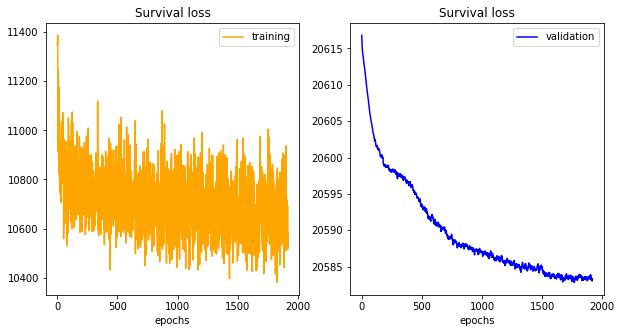

In [16]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(train_losses, color = 'orange', label = 'training')
plt.legend()
plt.title('Survival loss')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot(valid_losses, color = 'blue', label = 'validation')
plt.legend()
plt.title('Survival loss')
plt.xlabel('epochs')

plt.show()

# Evaluate Concordance Index on test set

Note: we convert predictions to original time scale and we compare with true time of events; this is done in order to make it comparable with other models

In [17]:
best_net.eval()
prediction_test_set = best_net(X_test)
expected_survival_times = compute_expected_survival_time(prediction_test_set,n_times,T_max)

In [18]:
C = concordance_index(test.time_event, 
                  expected_survival_times, 
                  test.status)

print('Concordance Index on test set:',np.round(C*100,2),'%')

Concordance Index on test set: 68.14 %


In [19]:
# save model
torch.save(best_net.state_dict(), '../../data/deepHit_weights.pt')